In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("Vasai.Rice.csv")
df['Price Date'] = pd.to_datetime(df['Price Date'], format='%d %b %Y').dt.strftime('%Y-%m-%d')
df.drop(['Min Price (Rs./Quintal)','Max Price (Rs./Quintal)',], axis=1, inplace = True)
df.rename(columns={'Modal Price (Rs./Quintal)':'Price', 'Price Date': 'Date'}, inplace = True)
df.set_index('Date', inplace = True)
df.sort_index(inplace = True)
df.index = pd.to_datetime(df.index)
df

,Price
Date,
2004-12-29,1450
2005-01-09,630
2005-01-10,630
2005-01-13,725
2005-01-17,1300
...,...
2024-02-14,3790
2024-02-16,3860
2024-02-19,3425


In [3]:

df = df.resample('D').first()

df['Price'].interpolate(method='pchip', inplace=True)
df

,Price
Date,
2004-12-29,1450.000000
2004-12-30,1312.819935
2004-12-31,1187.242675
2005-01-01,1073.576258
2005-01-02,972.128725
...,...
2024-02-18,3537.777778
2024-02-19,3425.000000
2024-02-20,3430.733083


In [4]:
df


,Price
Date,
2004-12-29,1450.000000
2004-12-30,1312.819935
2004-12-31,1187.242675
2005-01-01,1073.576258
2005-01-02,972.128725
...,...
2024-02-18,3537.777778
2024-02-19,3425.000000
2024-02-20,3430.733083


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,6995.0,2458.242533,873.435324,630.0,1653.399699,2504.095128,3150.0,4490.0


In [6]:
print(df['Price'].min())

630.0


In [7]:
print(df['Price'].min())

630.0


<Axes: xlabel='Date'>

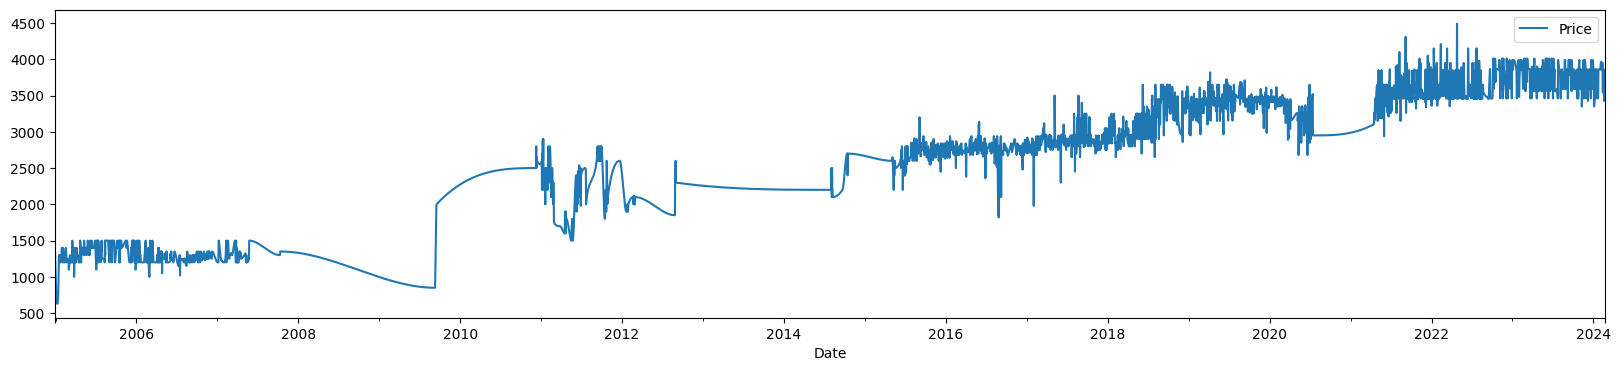

In [8]:
df.plot(figsize=(20, 4))

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [10]:
result = seasonal_decompose(df, model="multiplicative")

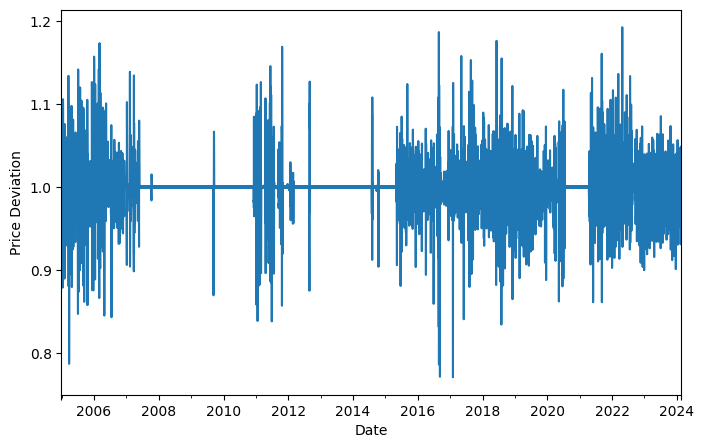

In [11]:
result.resid.plot(figsize=(8, 5))
plt.ylabel("Price Deviation")
plt.show()

In [12]:
PREDICTION_DAYS = 28

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [15]:
sequence_length = 56

In [16]:
X, y = [], []

sequences = []

for i in range(len(df) - sequence_length):
    X.append(scaled_data[i:(i + sequence_length)])
    y.append(scaled_data[(i + sequence_length)][0])

X = np.array(X)
y = np.array(y)

In [17]:
X.shape, y.shape

((6939, 56, 1), (6939,))

In [18]:
split = int(0.8 * len(X))

In [19]:
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

In [57]:
X_train.shape
y_train.shape

(5551,)

In [20]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential(
    [
        LSTM(units=64, return_sequences=True, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units=64, return_sequences=False),
        Dense(units=1),
    ]
)

model.compile(optimizer="adam", loss="mean_squared_error")

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 56, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 49985 (195.25 KB)
Trainable params: 49985 (195.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
history = model.fit(X_train, y_train, batch_size=28, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10

199/199 [==============================] - 8s 31ms/step - loss: 0.0055 - val_loss: 0.0023
Epoch 2/10
199/199 [==============================] - 7s 33ms/step - loss: 8.1029e-04 - val_loss: 0.0019
Epoch 3/10
199/199 [==============================] - 7s 36ms/step - loss: 7.7898e-04 - val_loss: 0.0022
Epoch 4/10
199/199 [==============================] - 7s 35ms/step - loss: 7.4751e-04 - val_loss: 0.0020
Epoch 5/10
199/199 [==============================] - 6s 32ms/step - loss: 7.1150e-04 - val_loss: 0.0018
Epoch 6/10
199/199 [==============================] - 6s 32ms/step - loss: 6.9376e-04 - val_loss: 0.0023
Epoch 7/10
199/199 [==============================] - 6s 32ms/step - loss: 6.8880e-04 - val_loss: 0.0018
Epoch 8/10
199/199 [==============================] - 6s 31ms/step - loss: 6.4452e-04 - val_loss: 0.0017
Epoch 9/10
199/199 [==============================] - 6s 30ms/step - loss: 6.2718e-04 - val_loss: 0.0017
Epoch 10/10
199/199 [==============================] - 6s 

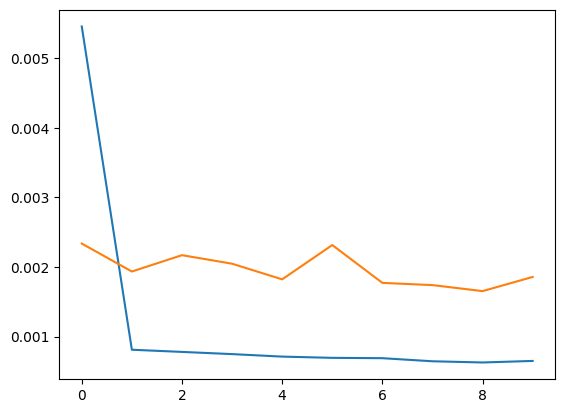

In [23]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [24]:
from joblib import dump, load

In [27]:
#model = load("./out/forecast.LSTM.Vasai.joblib")

FileNotFoundError: [Errno 2] No such file or directory: './out/forecast.LSTM.Vasai.joblib'

In [59]:
x_test = scaled_data[-sequence_length:]
x_test = np.array([x_test])

In [60]:
x_test.shape

(1, 56, 1)

In [61]:
predictions = model.predict(X)

217/217 [==============================] - 2s 11ms/step


In [62]:
predictions = predictions.reshape(-1,1)
predictions = scaler.inverse_transform(predictions).flatten()


In [64]:
from datetime import timedelta

In [65]:
future_dates = [df.index[-1] + timedelta(days=i) for i in range(1, 29)]

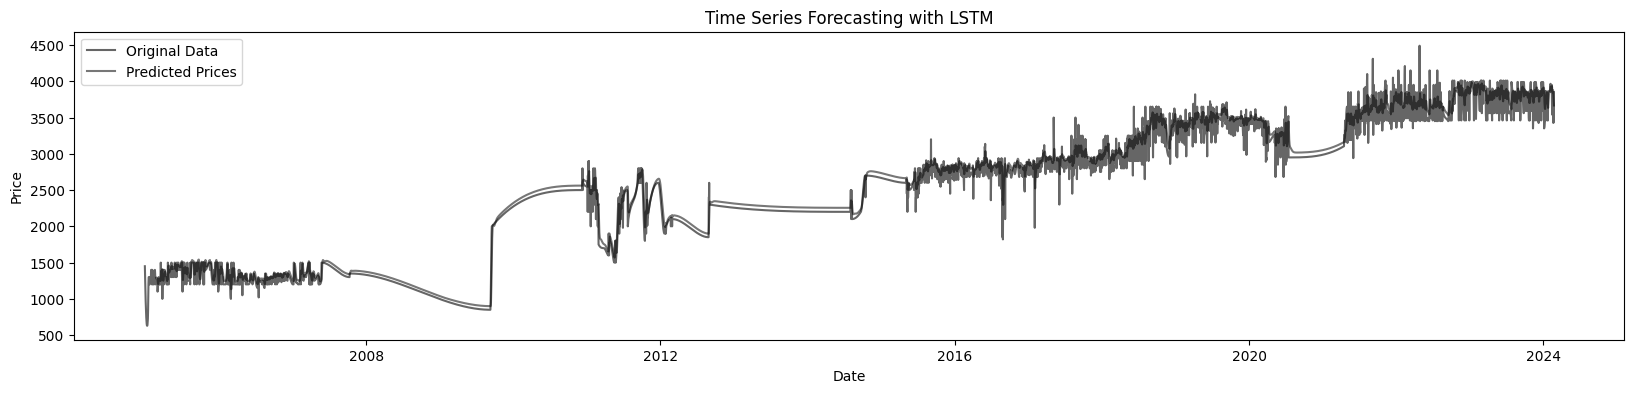

In [66]:
plt.figure(figsize=(20, 4))
plt.plot(df.index, df['Price'], label='Original Data', c="#666666")
plt.plot(df.index[sequence_length:], predictions, label='Predicted Prices', c="#00000088")
plt.title('Time Series Forecasting with LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

(
    mean_absolute_error(predictions, df["Price"][sequence_length:]),
    mean_squared_error(predictions, df["Price"][sequence_length:], squared=False),
)

C:\Users\karan\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(86.90049691201659, 119.70194698352145)